### Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from scipy import stats
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib qt
%matplotlib inline


### Camera Calibration
Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

A class called `Camera` which consists of `calibrate`, `undistort`, `warper` and `unwarp` functions is created. 

The `calibrate ` function takes images from the camera_cal folder (images of a chessboard taken at a different angles and distances) for calibration. The `objpoints` which are chessboard corner 3D points (x,y,z) are assumed to be on a flat image; z=0. The  coordinates of the corners in 2D images are referred to as `imgpoints`. Using OpenCV `findChessboardCorners` function, the corners (`nx` = 9 by  `ny` = 6) of distorted images are detected. If the function successfully detects the corners, the `imgpoints` and `objpoints` are appended. The `objpoints` and `imgpoints`are used in OpenCV `calibrateCamera()` function to obtain distortion coefficients `dist` along with the camera matrix `mtx`. These are used in `undistort()` function to undistort the image.

The perspective transform was performed by a  function called `warper()` to rectify the image. The `Camera` class uses openCV `getPerspectiveTransform()` to get the transform matrix, M. The vertices of the  four source (`src`) and destination (`dst`) points are hardcoded by observation. Using the transform matrix, the top-down view of the image is produced in `warper()` function by applying `warpPerspective()`. 

The source and destination points are:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 190, 668      | 320, 720        | 
| 1090, 668      | 920, 720      |
| 780, 480     | 920, 0      |
| 500, 480      | 320, 0        |

The `unwarp()` function changes back the warped image back to the original view of the image.  

The following cells below shows the results of the `calibrate ` and `undistort` functions. 

In [2]:
class Camera: 
    def __init__(self):
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        self.shape = None 
        
        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
        
        # src and dst points for perspective transform 
        src =  np.float32([[190,668], [1090,668], [780,480], [500,480]]) 
        dst =  np.float32([[320,720], [920,720], [920,0], [320,0]])
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)
    
    def calibrate(self,visualize):   
        
        #dimensions of chessboard         
        nx, ny = 9, 6  
        objp = np.zeros((nx * ny, 3), np.float32) # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1, 2)  # x, y coordinates
        
        if(visualize):
            fig, ax = plt.subplots(5,4, figsize=(16, 11))
            fig.subplots_adjust(hspace =0.2, wspace=0.1)
            ax = ax.ravel()
            i = 0 

        for images in glob.glob('./camera_cal/calibration*.jpg'):
            img = cv2.imread(images)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.shape = gray.shape[::-1]
            
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
            if ret is True:
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
            
            if (visualize):
                img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                ax[i].axis('off')
                ax[i].imshow(img)
                i+=1
        ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, self.shape, None, None)

    def undistort(self, img): 
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def warper(self, img):
        # keep same size as input image
        return cv2.warpPerspective(img, self.M, self.shape, flags=cv2.INTER_LINEAR)  
        
    def unwarp(self,img):
        return cv2.warpPerspective(img, self.M_inv, self.shape, flags=cv2.INTER_LINEAR)


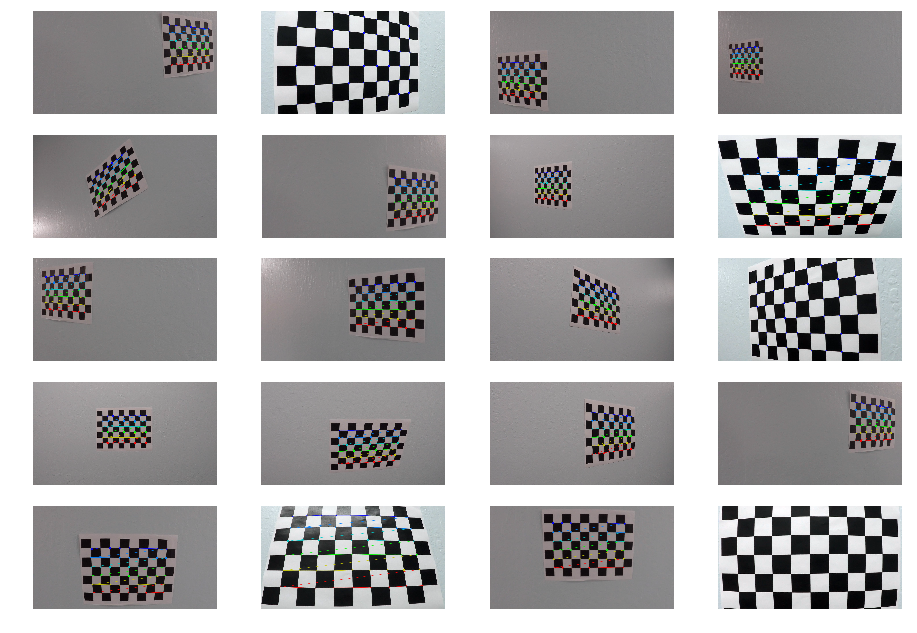

In [3]:
camera = Camera()
camera.calibrate(True)

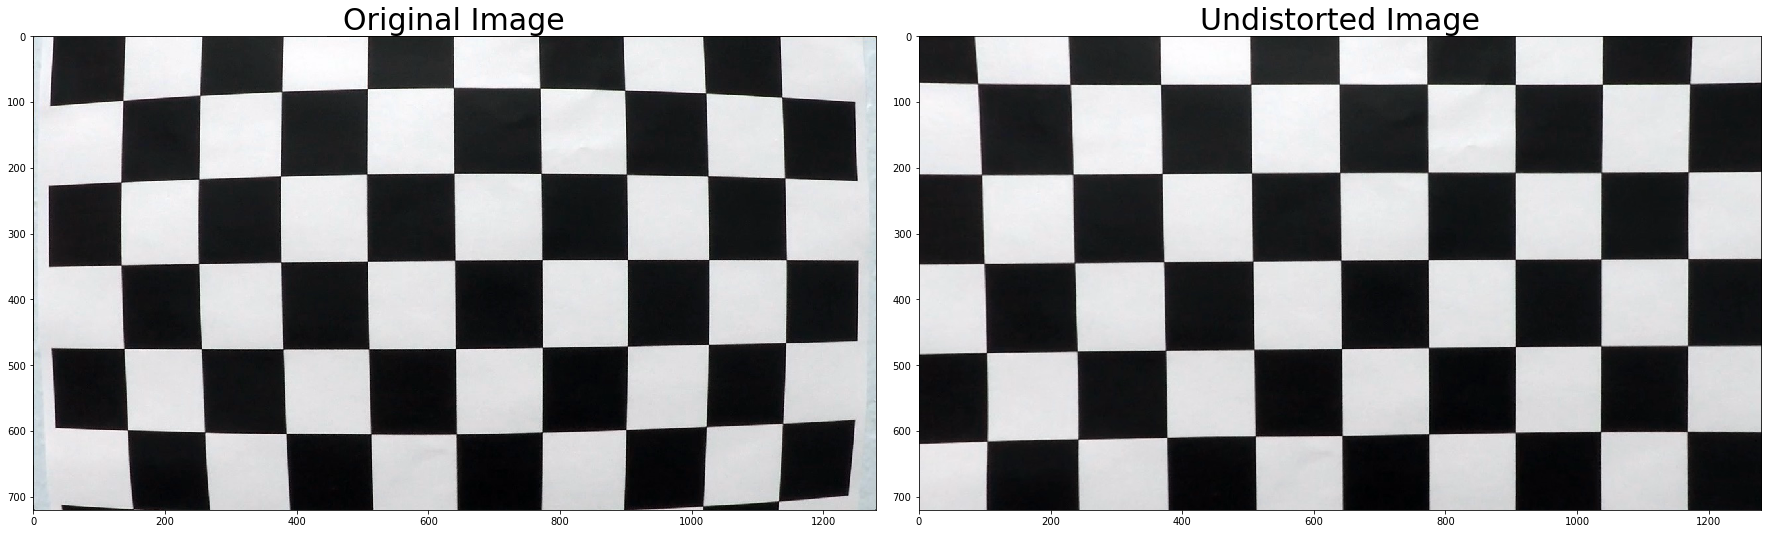

In [4]:
# Applying a distortion correction to raw images
img = cv2.imread('./camera_cal/calibration1.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(camera.undistort(img))
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline (single images)
#### 1. Provide an example of a distortion-corrected image.
The original, distortion-corrected, warped and unwarped images are shown below.

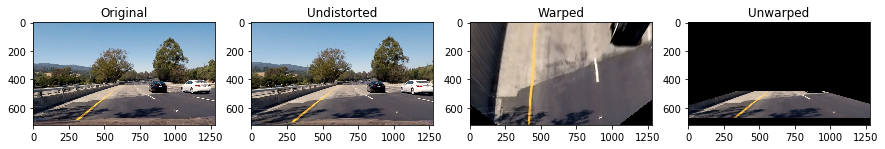

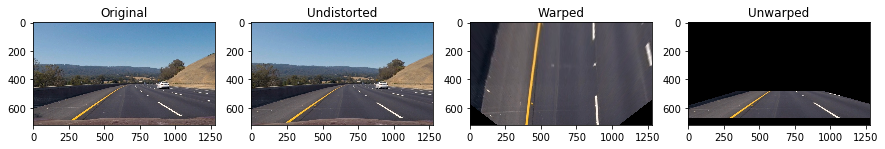

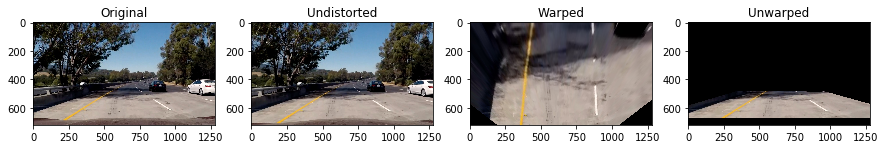

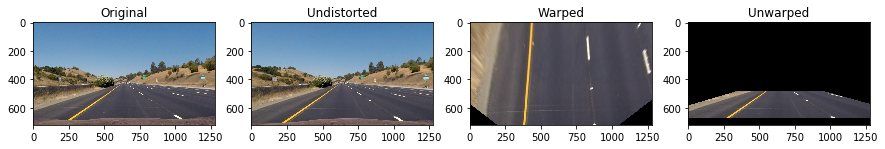

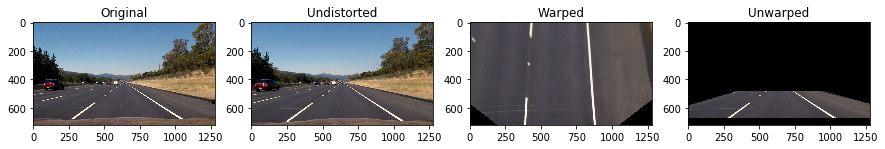

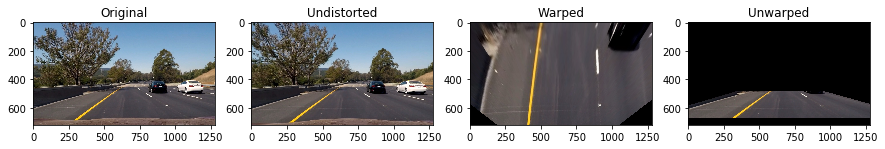

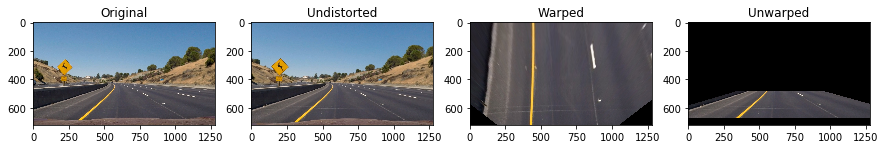

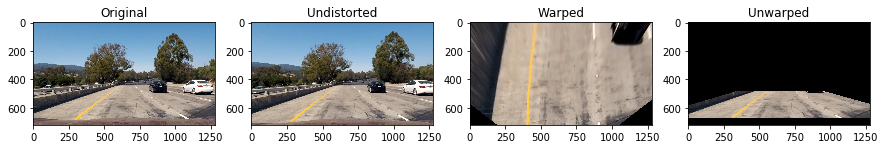

In [5]:
for images in glob.glob('./test_images/*.jpg'):
    img = cv2.imread(images)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_figwidth(15)
    
    ax1.imshow(img)
    ax1.set_title('Original')
    
    undist = camera.undistort(img)
    ax2.imshow(undist)
    ax2.set_title('Undistorted')
    
    warped = camera.warper(undist)
    ax3.imshow(warped)
    ax3.set_title('Warped')
    
    unwarped = camera.unwarp(warped)
    ax4.imshow(unwarped)
    ax4.set_title('Unwarped')
    plt.show()

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
The binary result was produced with several combinations of opencv functions and the pipeline is shown in `binarize_pipeline`. To detect the lanes, the images are observed in different color spaces and the color space studies are shown in the first cell below. From the observations, S and Cb channels, and H, L and S channels picks up best for yellow and white lanes respectively. Thus, yellow and white color thresholding is done separately and each are detected in `color threshold` function. Depending on the lightning conditions, white lanes are detected with combination of H and L or L and S channels. If too many pickels (more than 10000 pixels) are picked up from H and L combination, L and S combination is used instead. The binary results from each colors are combined with a combination condition as (`white` = 1 and `yellow`= 1). Lastly, only the pixels for regions of interest are considered for better visualization of lanes. The results are shown below.


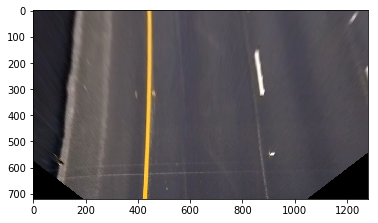

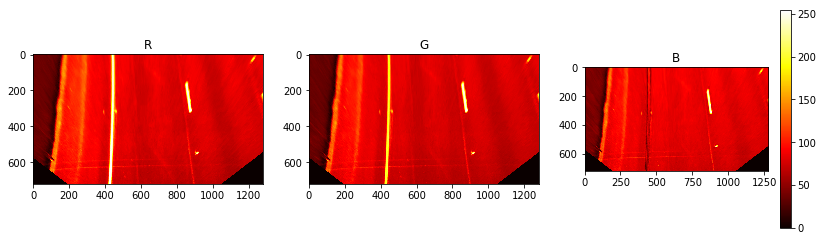

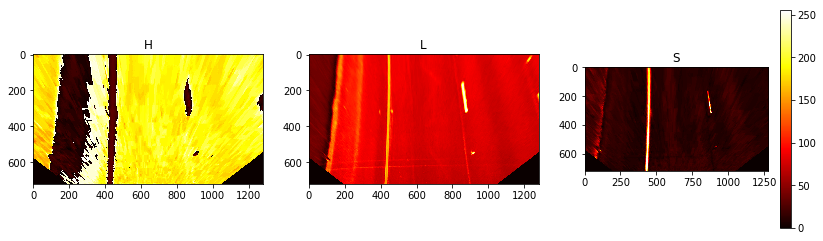

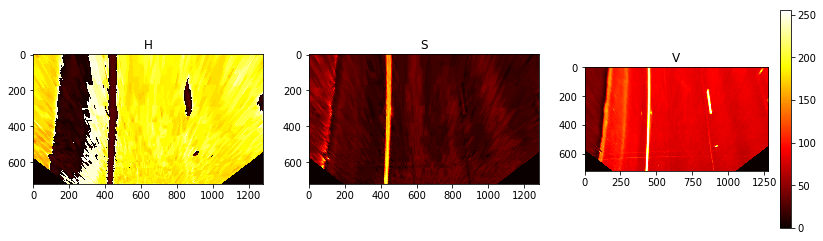

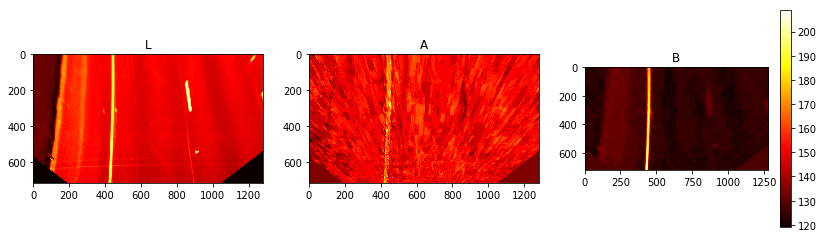

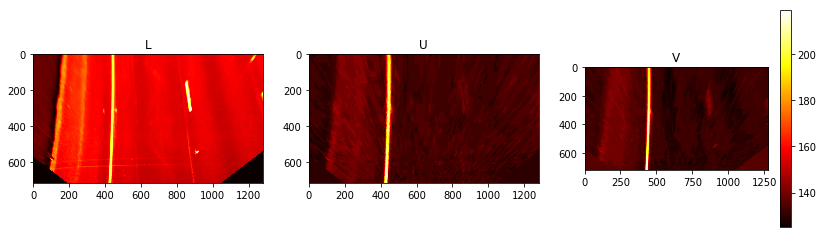

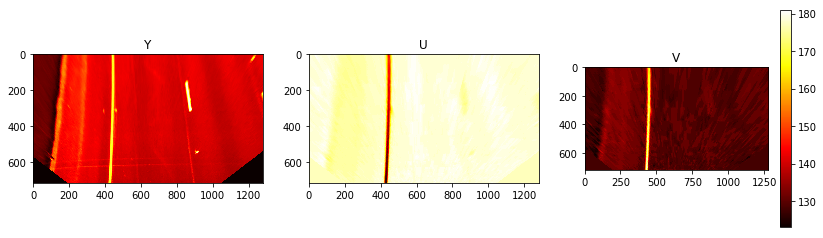

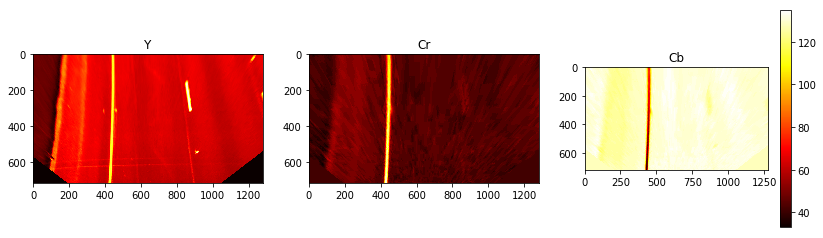

In [6]:
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = camera.undistort(img)
img = camera.warper(img)

plt.imshow(img)

colorspaces = [
    (img, 'RGB'),
    (cv2.cvtColor(img, cv2.COLOR_RGB2HLS), 'HLS'),
    (cv2.cvtColor(img, cv2.COLOR_RGB2HSV), 'HSV'),
    (cv2.cvtColor(img, cv2.COLOR_RGB2LAB), 'LAB'),
    (cv2.cvtColor(img, cv2.COLOR_RGB2LUV), 'LUV'),
    (cv2.cvtColor(img, cv2.COLOR_RGB2YUV), 'YUV'),
    (cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb), ['Y', 'Cr', 'Cb']),
]


for image, channels in colorspaces:
    fig, axes = plt.subplots(1, 3)
    fig.set_figwidth(14)
    for i in range(3):
        img = image[:, :, i]
        im = axes[i].imshow(img, cmap=plt.cm.hot)
        axes[i].set_title(channels[i])
        if i == 2:
            plt.colorbar(im, ax=axes[i])
    plt.show()

In [7]:
vertices = np.array([[(190,668), (1090,668), (780,480), (500,480)]],dtype=np.int32)     


def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    if (orient=='x'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    else: 
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    abs_sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    abs_sobel = np.sqrt(abs_sobelx*abs_sobelx+abs_sobely*abs_sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))   
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def color_threshold(img, thresh1, thresh2,color):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if(color == 0):
        YCrCb=cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        s_channel = hls[:,:,2]
        cb_channel = YCrCb[:,:,2]
        binaryS = np.zeros_like(s_channel)
        binaryCb = np.zeros_like(cb_channel)
        binaryS[(s_channel > thresh1[0]) & (s_channel<= thresh1[1])] = 1
        binaryCb[(cb_channel > thresh2[0]) & (cb_channel<= thresh2[1])] = 1
        combined = np.zeros_like(binaryS)
        combined[((binaryS==1) & (binaryCb==1))] = 1
        return region_of_interest(combined)

    elif(color == 1):
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        binaryH = np.zeros_like(h_channel)
        binaryL = np.zeros_like(l_channel)
        binaryH[(h_channel > thresh1[0]) & (h_channel<= thresh1[1])] = 1
        binaryL[(l_channel  > thresh2[0]) & (l_channel <= thresh2[1])] = 1
        combined = np.zeros_like(binaryH)
        combined[((binaryH==1) & (binaryL==1))] = 1
        return region_of_interest(combined)
    
    else:
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        binaryL = np.zeros_like(l_channel)
        binaryS = np.zeros_like(s_channel)
        binaryL[(l_channel  > thresh1[0]) & (l_channel <= thresh1[1])] = 1
        binaryS[(s_channel > thresh2[0]) & (s_channel<= thresh2[1])] = 1
        combined = np.zeros_like(binaryL)
        combined[((binaryL==1) & (binaryS==1))] = 1
        return region_of_interest(combined)

    
def gaussian_blur(img, kernel_size=3):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    mask = np.zeros_like(img)   
    cv2.fillPoly(mask, vertices, 1)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



Text(0.5,1,'White Detected')

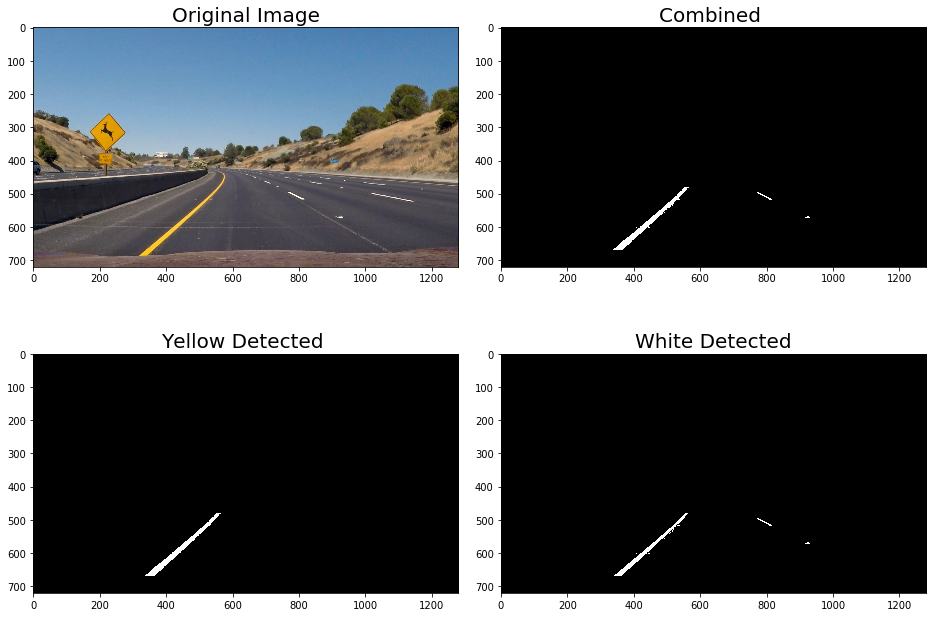

In [8]:
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

orig = img 
yellow = color_threshold(img,(75,255),(0,115),0)
white= color_threshold(img,(0,50), (110,255),1)

if(np.count_nonzero(white)>10000):
    white= color_threshold(img,(110,255), (100,255),2)
    
combined = np.zeros_like(yellow)
combined[((yellow==1) | (white==1))] = 1

fig, ax = plt.subplots(2,2, figsize=(16, 11))
fig.subplots_adjust(hspace =0.2, wspace=0.1)
ax = ax.ravel()
ax[0].imshow(orig)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow((combined), cmap='gray')
ax[1].set_title('Combined ', fontsize=20)
ax[2].imshow((yellow), cmap='gray')
ax[2].set_title('Yellow Detected ', fontsize=20)
ax[3].imshow(white, cmap='gray')
ax[3].set_title('White Detected', fontsize=20)



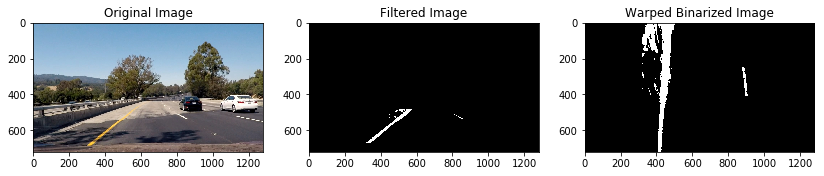

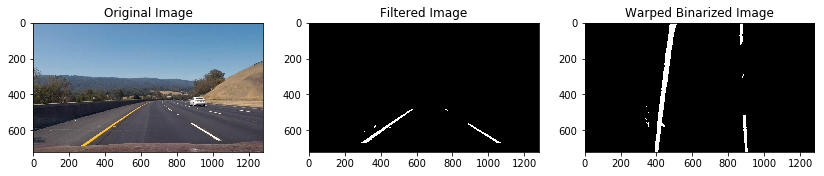

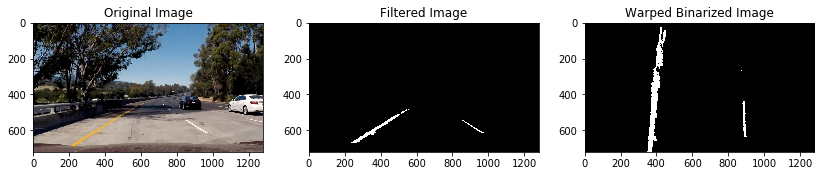

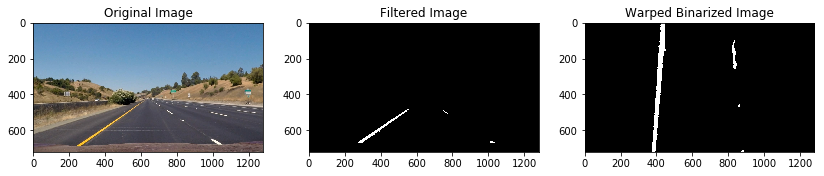

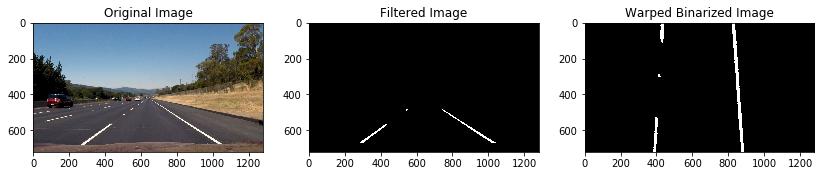

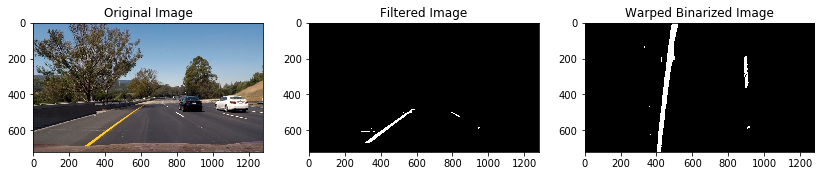

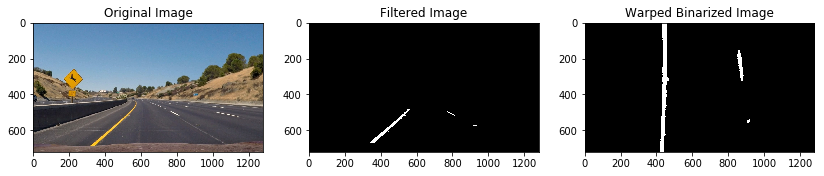

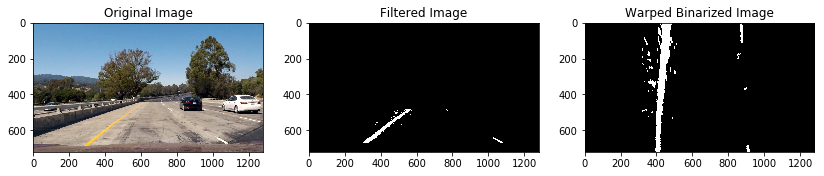

In [9]:
def binarize_pipeline(img,first):
    undistorted = camera.undistort(img) 
    yellow = color_threshold(undistorted,(75,255),(0,115),0)
    white= color_threshold(undistorted,(0,50), (110,255),1)
    if(np.count_nonzero(white)>10000):
        white= color_threshold(img,(110,255), (100,255),2)
    combined = np.zeros_like(yellow)
    combined[((yellow==1) | (white==1))] = 1
    return combined
        


for images in glob.glob('./test_images/*.jpg'):
#for images in glob.glob('./challenge/*.PNG'):
    img = cv2.imread(images)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figwidth(14)
    ax1.imshow(img)
    ax1.set_title('Original Image')
    combined_ROI = binarize_pipeline(img,True)
    ax2.imshow((combined_ROI), cmap='gray')
    ax2.set_title('Filtered Image')
    ax3.imshow(camera.warper(combined_ROI), cmap='gray')
    ax3.set_title('Warped Binarized Image')
    plt.show()


#### 3. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

A class called `Lane` which consists of `find_lane_pixels_sliding_window`, `fit_poly`, `drawSlidingWin`, `draw_lane_info`, `measure_curvature_pixels` and `advanced_lane_process`functions is created. 

The initial lane pixels are found by finding peaks in a histogram. `find_lane_pixels_sliding_window` function takes the binary_warped image as an input and takes a histogram along all the columns in the lower half of the image. Taking the summation of the columns results in two prominent peaks. These peaks are the starting point to search for lane pixels. Then the function slides window moving upward in the image to determine where the lane lines stretch. Whenever the pixel contains nonzero values and are within the predefined window, the indices of the points are appended in `lef_lane_inds` and `right_lane_inds`. After determining which pixels belong to which line, finding the polynomial that fits the line are computed using in`fit_poly` function, which uses `polyfit` function. There is a flag which tells if the detected lines are good, warning or bad. When the picked up pixels on either right or left lanes are enough to give good starting point but do not have sufficient number of pixels  (< 800 pixels), while the other lane have sufficient number of pixels the flag is set to warning status. For this case, the the approximtes from the good line is used to estimate both of the lanes. If enough pixels are not detected for both right and left lane, or the computed polynomial is not a good approximate (the coefficient of the second degree term is > 0.001) it is considered as a bad detection. For bad detection, previously stored points are used to estimate the lanes assuming that the lanes have not drastically changed from previously good detected frame. For other cases, the detected lanes are assumed as a good detection. The result is shown below.



In [10]:
class Lane():
    def __init__(self):
        self.leftx = []
        self.lefty = []
        self.rightx = [] 
        self.righty = []
        self.left_fit = []
        self.right_fit = []
        self.left_fitx = []
        self.right_fitx = []
        self.ploty=[]
        self.pre_left_fit = []
        self.pre_right_fit = []

        self.imgshape = []
        self.left_curverad = []
        self.right_curverad = []
        self.pos_veh = []
        self.flag = 0  # 0 = Bad Detection, 1 = Warning, 2 = Good 
        
    def find_lane_pixels_sliding_window(self, binary_warped,nwindows=9,margin=80,minpix=50,show=True):
        self.imgshape = binary_warped.shape
        histogram = np.sum(binary_warped[self.imgshape[0]//2:,:], axis=0)
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        window_height = np.int(binary_warped.shape[0]//nwindows)
    
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])    #Find x and y positions of all nonzero pixels in the image
        nonzerox = np.array(nonzero[1])
    
        leftx_current = leftx_base          #Positions to be updated later for each window in nwindows 
        rightx_current = rightx_base
        left_lane_inds = []                  
        right_lane_inds = []

        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.imgshape[0] - (window+1)*window_height
            win_y_high = self.imgshape[0] - window*window_height

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            if(show):
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                (win_xleft_high,win_y_high),(0,255,0), 5) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),
                (win_xright_high,win_y_high),(0,255,0), 5) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))    

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]
        
        self.flag = 2      # 0 = Bad Detection, 1 = Warning, 2 = Good 
        
        if(leftx_base < midpoint and rightx_base > midpoint):
            if(len(self.leftx) and len(self.leftx)<800 and len(self.rightx)>1000):
                self.leftx = leftx_base + (self.rightx-rightx_base) 
                self.lefty = self.righty
                self.flag = 1

            if(len(self.rightx) and len(self.rightx)<800 and len(self.leftx)>1000):
                avgRgt = stats.mode(self.rightx)[0]
                self.rightx = rightx_base + (self.leftx-leftx_base) 
                self.righty = self.lefty
                self.flag = 1

        return out_img
    
    def fit_poly(self):
        if(len(self.rightx)==0 or  len(self.leftx)==0):
            self.flag = 0 
        else: 
            self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
            self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        
            if(abs(self.left_fit[0])>0.001 or abs(self.right_fit[0])>0.001):
                self.flag = 0
                self.ploty = np.linspace(0, self.imgshape[0]-1, self.imgshape[0])
                self.left_fitx = self.pre_left_fit[0]*self.ploty**2+self.pre_left_fit[1]*self.ploty + self.pre_left_fit[2]
                self.right_fitx = self.pre_right_fit[0]*self.ploty**2 + self.pre_right_fit[1]*self.ploty + self.pre_right_fit[2]
            
            else: 
                self.ploty = np.linspace(0, self.imgshape[0]-1, self.imgshape[0])
                self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
                self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

        
  
    
    def drawSlidingWin(self,img,binary):
        warped = camera.warper(binary)
        out_img = self.find_lane_pixels_sliding_window(warped, 8, 60,30,True)
        
        if(self.flag != 0):
            self.fit_poly()

            out_img[self.lefty, self.leftx] = [0, 0, 255]
            out_img[self.righty, self.rightx] = [255, 0, 0]

            fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
            fig.set_figwidth(10)
            ax1.imshow(img)
            ax1.set_title('Original Image')

            ax2.imshow(warped,cmap='gray')
            ax2.set_title('Warped Binarized Image ')

            # Plots the left and right polynomials on the lane lines
            plt.plot(self.left_fitx, self.ploty, color='yellow')
            plt.plot(self.right_fitx, self.ploty, color='yellow')
            ax3.imshow(out_img)
            ax3.set_title('Lane pixels using sliding window')
            plt.show()
    
    def draw_lane_info(self,img,binary_warped):
        img = camera.undistort(img)
        new_img = np.copy(img)
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        if(len(self.left_fitx) and len(self.right_fitx)):
            left_pts = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))])
            right_pts = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.ploty])))])
            pts = np.hstack((left_pts, right_pts))

            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
            cv2.polylines(color_warp, np.int32([left_pts]), isClosed=False, color=(255,0,255), thickness=15)
            cv2.polylines(color_warp, np.int32([right_pts]), isClosed=False, color=(0,255,255), thickness=15)
            newwarp = camera.unwarp (color_warp) 

            if(self.flag==2):
                rad_text = 'Radius of curvature: ' + '{:04.3f}'.format((self.left_curverad+self.right_curverad)/2) + 'm'
                cv2.putText(new_img, rad_text, (50,70), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,255,0), 2, cv2.LINE_AA)
                cen_text =  'Center offset: ' + '{:04.3f}'.format(self.pos_veh) + 'm '
                cv2.putText(new_img, cen_text, (50,120),  cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,255,0), 2, cv2.LINE_AA)
    
            elif(self.flag==1):
                cv2.putText(new_img, 'Warning', (50,70), cv2.FONT_HERSHEY_DUPLEX, 3, (255,0,0), 5, cv2.LINE_AA)
            else: 
                cv2.putText(new_img, 'Bad Lane Detection', (50,70), cv2.FONT_HERSHEY_DUPLEX, 3, (255,0,0), 5, cv2.LINE_AA)
            result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
        else:
            result = img
        return result


    def measure_curvature_pixels(self,binary_warped):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 
        xm_per_pix = 3.7/700
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        h = binary_warped.shape[0]-20  # offset 
        y_eval = np.max(self.lefty)
        
        if(self.leftx.size and self.rightx.size):
            left_fit_cr = np.polyfit(self.lefty*ym_per_pix, self.leftx*xm_per_pix,2)
            right_fit_cr = np.polyfit(self.righty*ym_per_pix, self.rightx*xm_per_pix,2)

            self.left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix +left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            self.right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            cen_lane = ((self.left_fit[0]*h**2 + self.left_fit[1]*h + self.left_fit[2])+(self.right_fit[0]*h**2 + self.right_fit[1]*h + self.right_fit[2]))/2
            self.pos_veh = abs(binary_warped.shape[1]/2-cen_lane)*xm_per_pix

    def advanced_lane_process(self,img):
        binary = binarize_pipeline(img,True)
        warped = camera.warper(binary)
        
        out_img = self.find_lane_pixels_sliding_window(warped, 8,60,30)
            
        if(self.flag ==2):    
            self.fit_poly()
            self.pre_left_fit = self.left_fit
            self.pre_right_fit = self.right_fit
            self.measure_curvature_pixels(warped)
            
        result = self.draw_lane_info(img,warped)
        return result


    



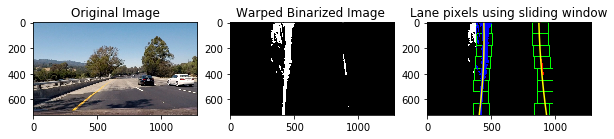

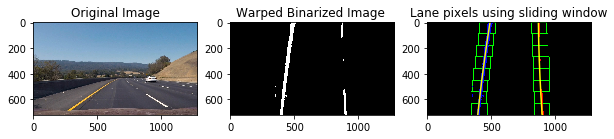

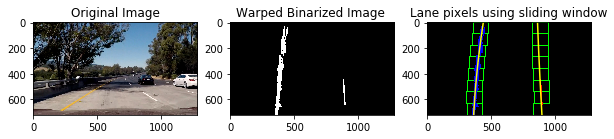

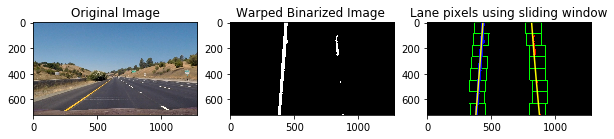

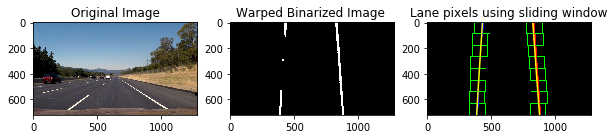

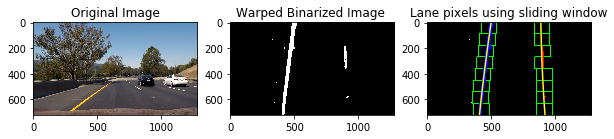

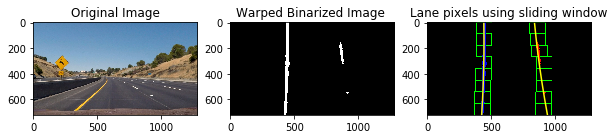

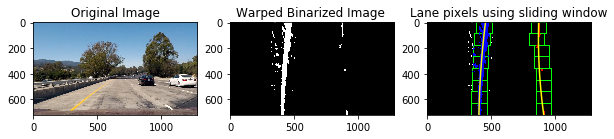

In [11]:
lane = Lane()
for images in glob.glob('./test_images/*.jpg'):
    img = cv2.imread(images)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    binary = binarize_pipeline(img,True)
    lane.drawSlidingWin(img,binary)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.



Calculating  the curvature of the lane and the position of the vehicle with respect to center is done in `measure_curvature_pixels` function. This funtion takes `leftx`, `lefty`,`rightx` and `righty` from `find_lane_pixels_sliding_window` function which are x and y positions of the lane pixels. The function calculates the second order polynomial `polyfit` function and the points with a conversion of pixels to [m] (`ym_per_pix`,`xm_per_pix`). The curvature is calculated by the raidus of curvature equation (R = (1+(2AY+B)^2)^1.5)/abs(2A)). The center of the car is calculated as the center of the image, and the center of the lane is calculated as the mean of the two lanes that are closest to the car. The difference bewteen the two multiplied with the conversion provides the offset of the car from the center of the lane in [m]. 


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

The final process is done in `advanced_lane_process` function. This function takes an image, performs camera calibration, applies distortion correction. The distortion corrected image is then checked for lane marks by applying color and gradient threshold and perspective transfrom is done to rectify the image. The rectified image's lane pixels are determined and the radius curvature and the offset of the car from the center of the lane is computed. The final result with lane area displayed is shown below. The results of the pipeline tested on the video is saved as 'project_video_output.mp4'. 

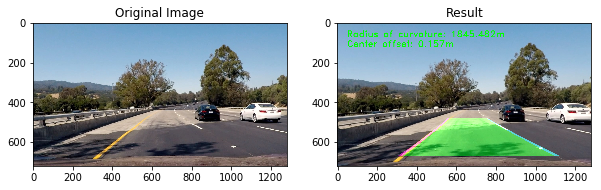

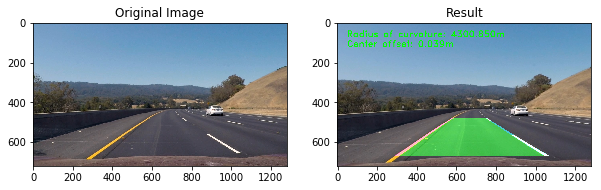

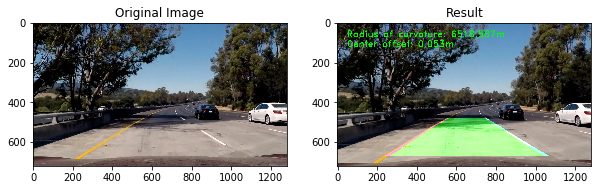

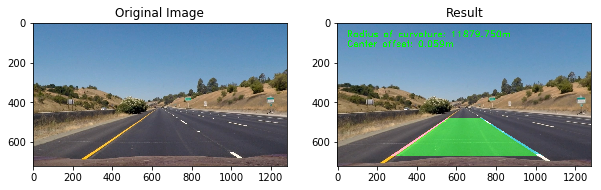

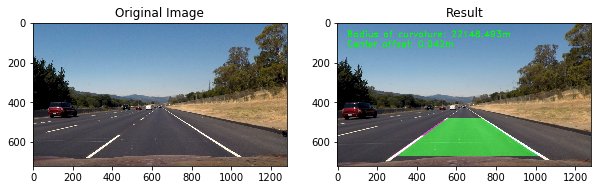

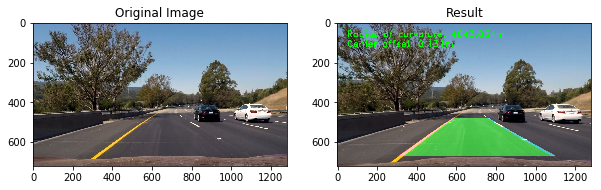

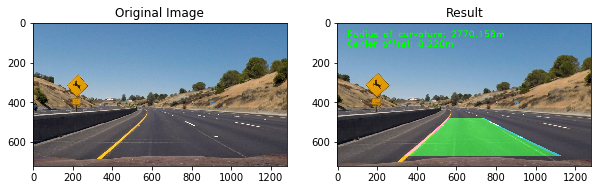

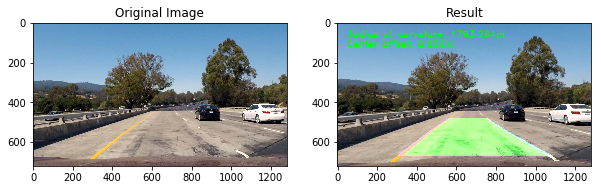

In [12]:
lane = Lane()
for images in glob.glob('./test_images/*.jpg'):
    img = cv2.imread(images)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    ax1.imshow(img)
    ax1.set_title('Original Image')
    
    ax2.imshow(lane.advanced_lane_process(img))
    ax2.set_title('Result')
        

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

In [ ]:
lane = Lane()
output = 'project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(lane.advanced_lane_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 99%|█████████▉| 1254/1261 [04:52<00:01,  4.11it/s]

In [ ]:
lane = Lane()
output2 = 'challenge_video_output.mp4'
clip2 = VideoFileClip("./challenge_video.mp4")
white_clip = clip2.fl_image(lane.advanced_lane_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output2, audio=False)

In [ ]:


output3 = 'harder_challenge_video_output.mp4'
clip3 = VideoFileClip("./harder_challenge_video.mp4")
white_clip = clip3.fl_image(lane.advanced_lane_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output3, audio=False)


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Under sufficient amount of lighting condition, the pipeline appears to work reasonbly well which is shown in project_video_output. However, varying lighting conditions such as going under the shades or tunnel in challenge videos, the pipeline fails. To mitigate some problem such as not detecting the enough lane marks, the algorithm uses the previous frames' coefficients to estimate the line. However, this still causes many faulty line detection in many frames. The current algoritm does not perform well with `challenge` or `harder challenge` video.  
